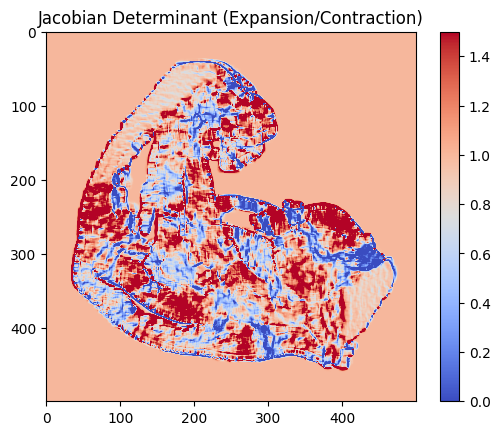

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_optical_flow(before, after):
    before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
    after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        before_gray, after_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    return flow


def generate_grid_points(image, n_rows, n_cols):
    # Check if the image has an alpha channel
    if image.shape[2] == 4:
        alpha = image[:, :, 3]
        _, mask = cv2.threshold(alpha, 127, 255, cv2.THRESH_BINARY)
    else:
        # Assuming a white background: threshold the grayscale image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Invert threshold if the arm is darker than the background
        _, mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    xx = np.linspace(x, x + w, n_cols + 1)
    yy = np.linspace(y, y + h, n_rows + 1)
    grid_x, grid_y = np.meshgrid(xx, yy)
    grid_points = np.stack([grid_x, grid_y], axis=-1)
    return grid_points

def interpolate_flow(flow, points):
    interpolated = []
    for (x, y) in points:
        x_floor, y_floor = int(np.floor(x)), int(np.floor(y))
        dx, dy = x - x_floor, y - y_floor
        if x_floor < 0 or y_floor < 0 or x_floor >= flow.shape[1]-1 or y_floor >= flow.shape[0]-1:
            interpolated.append((0.0, 0.0))
            continue
        # Bilinear interpolation for flow
        u_tl = flow[y_floor, x_floor, 0]
        u_tr = flow[y_floor, x_floor+1, 0]
        u_bl = flow[y_floor+1, x_floor, 0]
        u_br = flow[y_floor+1, x_floor+1, 0]
        u_top = (1 - dx) * u_tl + dx * u_tr
        u_bottom = (1 - dx) * u_bl + dx * u_br
        u = (1 - dy) * u_top + dy * u_bottom
        
        v_tl = flow[y_floor, x_floor, 1]
        v_tr = flow[y_floor, x_floor+1, 1]
        v_bl = flow[y_floor+1, x_floor, 1]
        v_br = flow[y_floor+1, x_floor+1, 1]
        v_top = (1 - dx) * v_tl + dx * v_tr
        v_bottom = (1 - dx) * v_bl + dx * v_br
        v = (1 - dy) * v_top + dy * v_bottom
        
        interpolated.append((u, v))
    return np.array(interpolated)

def compute_jacobians(grid_points, displaced_points, n_rows, n_cols):
    jacobian_matrix = np.zeros((n_rows, n_cols))
    for i in range(n_rows):
        for j in range(n_cols):
            A = grid_points[i, j]
            B = grid_points[i, j+1]
            C = grid_points[i+1, j+1]
            D = grid_points[i+1, j]
            
            A_disp = displaced_points[i, j]
            B_disp = displaced_points[i, j+1]
            C_disp = displaced_points[i+1, j+1]
            D_disp = displaced_points[i+1, j]
            
            X = np.array([A, B, C, D])
            U = np.array([A_disp[0]-A[0], B_disp[0]-B[0], C_disp[0]-C[0], D_disp[0]-D[0]])
            V = np.array([A_disp[1]-A[1], B_disp[1]-B[1], C_disp[1]-C[1], D_disp[1]-D[1]])
            
            # Solve for displacement gradients
            A_mat = np.hstack([X[:, :2], np.ones((4, 1))])
            coeffs_u, _, _, _ = np.linalg.lstsq(A_mat, U, rcond=None)
            a, b, _ = coeffs_u
            coeffs_v, _, _, _ = np.linalg.lstsq(A_mat, V, rcond=None)
            d, e, _ = coeffs_v
            
            F = np.array([[1 + a, b], [d, 1 + e]])
            jacobian_matrix[i, j] = np.linalg.det(F)
    return jacobian_matrix

# Parameters
n_rows, n_cols = 500, 500

# Load images
before = cv2.imread(r"E:\Projects\Muscle Check\bicep-1024.jpg", cv2.IMREAD_UNCHANGED)
after = cv2.imread(r"E:\Projects\Muscle Check\bicep-distort-1024.jpg", cv2.IMREAD_UNCHANGED)

# Compute optical flow
flow = compute_optical_flow(before[:, :, :3], after[:, :, :3])

# Generate grid on before image
grid_points = generate_grid_points(before, n_rows, n_cols)

# Calculate displaced grid points
points_flat = grid_points.reshape(-1, 2)
flow_flat = interpolate_flow(flow, points_flat)
displaced_flat = points_flat + flow_flat
displaced_points = displaced_flat.reshape(grid_points.shape)

# Compute Jacobian matrix
jacobian = compute_jacobians(grid_points, displaced_points, n_rows, n_cols)

# Save results
np.save('jacobian_determinants.npy', jacobian)

# Visualization
plt.imshow(jacobian, cmap='coolwarm', vmin=0.0, vmax=1.5)
plt.colorbar()
plt.title('Jacobian Determinant (Expansion/Contraction)')
plt.show()